In [160]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.preprocessing import scale, minmax_scale, robust_scale
pd.set_option('display.max_columns', None)

In [161]:
from functions.pipeline import *
from functions.test import *

In [162]:
# Definimos variables categóricas y numéricas
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
target = ['label']



In [268]:
data = pd.read_csv("../dataset.csv", sep=',', decimal='.')
data = data.drop_duplicates()
data = data.drop('split', axis=1)

# data[categorical_vars + target] = data[categorical_vars + target].astype(float).astype('Int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 865
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       865 non-null    float64
 1   sex       865 non-null    float64
 2   cp        865 non-null    float64
 3   trestbps  808 non-null    float64
 4   chol      839 non-null    float64
 5   fbs       783 non-null    float64
 6   restecg   864 non-null    float64
 7   thalach   810 non-null    float64
 8   exang     810 non-null    float64
 9   oldpeak   805 non-null    float64
 10  slope     570 non-null    float64
 11  ca        297 non-null    float64
 12  thal      413 non-null    float64
 13  label     865 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 101.4 KB


In [269]:
# convertimos a NA las medidas de chol 0 
data['chol'] = data['chol'].replace(0, np.nan)
data['trestbps'] = data['trestbps'].replace(0, np.nan)
# pasamos a valor absoluto los valores negativos de oldpeak
data.loc[data['oldpeak'] < 0, 'oldpeak'] = np.abs(data['oldpeak'])

In [270]:
pd.DataFrame(data[numerical_vars + categorical_vars].isna().sum().to_dict(), index=[f"Missing values - total"])


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
Missing values - total,0,58,185,55,60,0,0,82,1,55,295,568,452


In [271]:
# creamos 3 columnas para contar los nulos por fila, según el tipo de variable, y el total
data['num_na_count'] = data[numerical_vars].isnull().sum(axis=1)
data['cat_na_count'] = data[categorical_vars].isnull().sum(axis=1)
data['na_count'] = data['num_na_count'] + data['cat_na_count']
data['na_count'].value_counts()

0    286
3    217
2    196
4     82
7     43
1     25
8     11
5      4
6      1
Name: na_count, dtype: int64

In [272]:

data['age2'] = data['age'] // 10 
data['age2'].value_counts()

5.0    352
6.0    205
4.0    202
3.0     72
7.0     30
2.0      4
Name: age2, dtype: int64

In [273]:
data['oldpeak2'] = 0
data.loc[np.abs(data['oldpeak']) >= 1, 'oldpeak2'] = 1
# data.loc[(np.abs(data['oldpeak']) < 1) & (np.abs(data['oldpeak'])  > 0), 'oldpeak2'] = 1
data['oldpeak2'].value_counts()

0    510
1    355
Name: oldpeak2, dtype: int64

In [274]:
data['thalach'].describe()

count    810.000000
mean     137.717284
std       26.163654
min       60.000000
25%      120.000000
50%      140.000000
75%      158.000000
max      202.000000
Name: thalach, dtype: float64

In [275]:
data['thalach_max'] =  (200 - 0.7 * data['age'])
data['thalach_diff'] = data['thalach_max'] - data['thalach']
data['thalach_diff'].describe()

count    810.000000
mean      25.165432
std       24.479356
min      -32.800000
25%        5.700000
50%       23.300000
75%       42.750000
max      104.300000
Name: thalach_diff, dtype: float64

In [276]:
tmp = data[data['label'] == 0].groupby(['age2'])['oldpeak'].agg([np.mean])
tmp['mean'] = tmp['mean'].round(decimals=1)

In [277]:
# Creamos una nueva columna para cuantificar cuanto se desvía el valor de oldpeak de la media para casos no enfermos, por rango de edad

data = pd.merge(data, tmp[['mean']], on="age2", how="left")
data['oldpeak_diff'] = data['oldpeak'] - data['mean']
data['oldpeak_diff'].describe()

count    805.000000
mean       0.378385
std        1.014180
min       -0.900000
25%       -0.300000
50%        0.000000
75%        1.000000
max        5.400000
Name: oldpeak_diff, dtype: float64

In [278]:
data = data.drop('mean', axis=1)


In [279]:
# vamos a crear una columna para cuantificar puntos de riesgo de enfermedad
data['risks'] = 0

data.loc[data['age2'] == 5, 'risks'] += 1
data.loc[data['age2'] == 6, 'risks'] += 1

data.loc[data['chol'] >= 200, 'risks'] += 1
data.loc[data['chol'] >= 300, 'risks'] += 1

data.loc[data['trestbps'] >= 120, 'risks'] += 1
data.loc[data['trestbps'] >= 170, 'risks'] += 1

#data.loc[data['thalach'] <= 130, 'risks'] += 1
data.loc[(data['thalach_diff'] >= 33) | (data['thalach'] <= 120), 'risks'] += 1

# cp 4 en combinación con otro factor de riesgo
data.loc[(data['cp'].isin([1, 4])) & ((data['fbs'] == 1) | (data['exang'] == 1) | (data['oldpeak2'] == 1) | (data['restecg'] != 0)) , 'risks'] += 1

# depresión ST muy alta
data.loc[((data['oldpeak_diff'] > 0.1) | (data['oldpeak'] >= 1)), 'risks'] += 1
data.loc[data['oldpeak'] >= 2, 'risks'] += 1
# depresión ST por encima de la media, con pendiente plana o descendente
data.loc[((data['oldpeak_diff'] > 0.1) | (data['oldpeak'] >= 1)) & (data['slope'].isin([2, 3])), 'risks'] += 1

# vasos principales obstruidos
data.loc[data['ca'] == 1, 'risks'] += 2
data.loc[data['ca'] >= 2, 'risks'] += 1

# defecto de circulación de la sangre en el corazón
data.loc[data['thal'].isin([6,7]), 'risks'] += 2

In [283]:
data[(data['risks'] == 0) & (data['label'] != 0)  ]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label,num_na_count,cat_na_count,na_count,age2,oldpeak2,thalach_max,thalach_diff,oldpeak_diff,risks
594,49.0,1.0,3.0,NaN,142.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3,3,4,7,4.0,0,165.7,NaN,NaN,0
688,38.0,0.0,4.0,110.0,NaN,0.0,0.0,156.0,0.0,0.0,2.0,NaN,3.0,1,1,1,2,3.0,0,173.4,17.4,-0.2,0
855,38.0,1.0,4.0,110.0,196.0,0.0,0.0,166.0,0.0,0.0,NaN,NaN,NaN,1,0,3,3,3.0,0,173.4,7.4,-0.2,0


<Axes: >

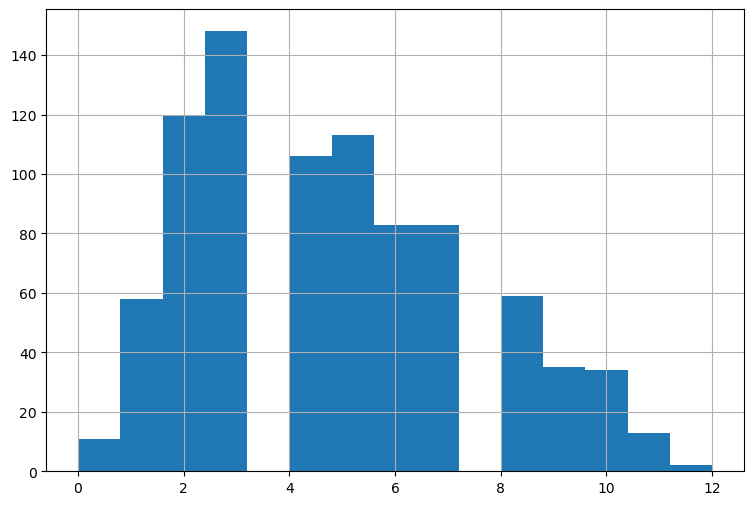

In [284]:
plt.figure(figsize=(9,6))
data['risks'].hist(bins=15)

In [285]:
data['ca'].value_counts()

0.0    173
1.0     65
2.0     39
3.0     19
9.0      1
Name: ca, dtype: int64

In [286]:
# 9 es un outlier, el máximo resultado posible es un 3
data['ca'] = data['ca'].replace(9, 3)

In [287]:
# Ahora vamos a analizar los outliers 
for var in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
    tmp_data = data[var].dropna()
    q1, q3 = np.quantile(tmp_data, 0.25), np.quantile(tmp_data, 0.75)
    iqr = q3 - q1
    lower, upper = q1 - iqr * 1.5, q3 + iqr * 1.5
    n_out = tmp_data[(tmp_data < lower) | (tmp_data > upper)].shape[0]
    print(f"{var} - min: {tmp_data.min()} - lower_limit: {lower} - Q1: {q1} - Q3: {q3} - IQR: {iqr} - upper_limit: {upper} - max: {tmp_data.max()} - outliers: {n_out}")
            


age - min: 28.0 - lower_limit: 27.5 - Q1: 47.0 - Q3: 60.0 - IQR: 13.0 - upper_limit: 79.5 - max: 77.0 - outliers: 0
trestbps - min: 80.0 - lower_limit: 90.0 - Q1: 120.0 - Q3: 140.0 - IQR: 20.0 - upper_limit: 170.0 - max: 200.0 - outliers: 26
chol - min: 85.0 - lower_limit: 109.625 - Q1: 209.0 - Q3: 275.25 - IQR: 66.25 - upper_limit: 374.625 - max: 603.0 - outliers: 21
thalach - min: 60.0 - lower_limit: 63.0 - Q1: 120.0 - Q3: 158.0 - IQR: 38.0 - upper_limit: 215.0 - max: 202.0 - outliers: 1
oldpeak - min: 0.0 - lower_limit: -2.25 - Q1: 0.0 - Q3: 1.5 - IQR: 1.5 - upper_limit: 3.75 - max: 6.2 - outliers: 13


In [288]:
data.loc[data['oldpeak'] > 3.75, 'oldpeak'] = 3.75
data.loc[data['chol'] > 350, 'chol'] = 350

In [289]:
# Tenemos un outlier de colesterol, en ese rango de edad es muy raro tener colesterol tan bajo
data[data['chol'] < 100] 


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label,num_na_count,cat_na_count,na_count,age2,oldpeak2,thalach_max,thalach_diff,oldpeak_diff,risks
750,56.0,1.0,4.0,120.0,85.0,0.0,0.0,140.0,0.0,0.0,NaN,NaN,NaN,0,0,3,3,5.0,0,160.8,20.8,-0.5,2


In [290]:
# Sustituimos el valor por 140, que es el mínimo que tenemos en nuestros datos para rangos de 40-50 y 50-60
data.loc[data['chol'] <= 100, 'chol'] = 140

In [291]:
data.loc[data['thalach'] < 63, 'thalach'] = 63

In [292]:
data.loc[data['trestbps'] < 90, 'trestbps'] = 90
data.loc[data['trestbps'] > 170, 'trestbps'] = 175


In [227]:
data[['fbs', 'restecg', 'exang', 'ca']] +=  1
data[categorical_vars] = data[categorical_vars].replace(np.nan, 0)

In [228]:
vals = { col: [sorted(list(data[col].dropna().unique()))] for col in categorical_vars }
pd.DataFrame(vals, index=['Unique values']).transpose()

,Unique values
sex,"[0.0, 1.0]"
cp,"[1.0, 2.0, 3.0, 4.0]"
fbs,"[0.0, 1.0, 2.0]"
restecg,"[0.0, 1.0, 2.0, 3.0]"
exang,"[0.0, 1.0, 2.0]"
slope,"[0.0, 1.0, 2.0, 3.0]"
ca,"[0.0, 1.0, 2.0, 3.0, 4.0]"
thal,"[0.0, 3.0, 6.0, 7.0]"


In [229]:
import miceforest as mf

In [230]:
y = data['label']
data = data.drop('label', axis=1)
# Create kernels. 
kernel = mf.ImputationKernel(
  data=data,
  save_all_iterations=True,
  random_state=1
)

In [231]:
kernel.mice(50)

In [232]:
data = kernel.complete_data()

data[numerical_vars].describe()

,age,trestbps,chol,thalach,oldpeak
count,865.000000,865.000000,865.000000,865.000000,865.000000
mean,53.431214,131.658960,241.813873,136.248555,0.809538
std,9.475490,17.746557,48.170740,27.196549,1.001540
min,28.000000,90.000000,117.000000,63.000000,0.000000
25%,47.000000,120.000000,207.000000,118.000000,0.000000
50%,54.000000,130.000000,237.000000,139.000000,0.200000
75%,60.000000,140.000000,274.000000,157.000000,1.500000
max,77.000000,175.000000,350.000000,202.000000,3.750000


In [233]:
data['label'] = y

In [234]:
data.sample(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_na_count,cat_na_count,na_count,age2,oldpeak2,thalach_max,thalach_diff,oldpeak_diff,risks,label
117,38.0,1.0,4.0,120.0,282.0,1.0,1.0,170.0,1.0,0.0,0.0,0.0,0.0,0,3,3,3.0,0,173.4,3.4,-0.2,2,1
818,62.0,1.0,3.0,160.0,315.0,1.0,1.0,72.0,2.0,0.0,2.0,0.0,3.0,1,1,2,6.0,0,156.6,84.6,-0.8,3,3
416,58.0,1.0,4.0,160.0,256.0,2.0,3.0,113.0,2.0,1.0,1.0,0.0,0.0,0,2,2,5.0,1,159.4,46.4,0.5,6,3
409,58.0,1.0,4.0,128.0,259.0,1.0,3.0,130.0,2.0,3.0,2.0,3.0,7.0,0,0,0,5.0,1,159.4,29.4,2.5,10,3
676,62.0,0.0,3.0,130.0,263.0,1.0,1.0,97.0,1.0,1.2,2.0,2.0,7.0,0,0,0,6.0,1,156.6,59.6,0.4,10,2
814,40.0,1.0,3.0,130.0,281.0,1.0,1.0,167.0,1.0,0.0,0.0,0.0,0.0,0,3,3,4.0,0,172.0,5.0,-0.3,2,0
645,41.0,1.0,4.0,110.0,172.0,1.0,3.0,158.0,1.0,0.0,1.0,1.0,7.0,0,0,0,4.0,0,171.3,13.3,-0.3,3,1
515,74.0,1.0,2.0,145.0,207.0,0.0,2.0,123.0,1.0,1.3,1.0,0.0,0.0,1,3,4,7.0,1,148.2,25.2,0.4,2,1
656,63.0,1.0,4.0,140.0,243.0,0.0,3.0,149.0,1.0,2.0,1.0,0.0,0.0,1,3,4,6.0,1,155.9,6.9,1.2,5,2
753,37.0,1.0,3.0,130.0,194.0,1.0,1.0,150.0,1.0,0.0,0.0,0.0,0.0,0,3,3,3.0,0,174.1,24.1,-0.2,1,0


In [235]:
pd.DataFrame(data.isna().sum().to_dict(), index=[f"Missing values - total"])


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_na_count,cat_na_count,na_count,age2,oldpeak2,thalach_max,thalach_diff,oldpeak_diff,risks,label
Missing values - total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [241]:
data['thalach_max'] =  (200 - 0.7 * data['age'])
data['thalach_diff'] = data['thalach_max'] - data['thalach']


In [242]:
data = pd.merge(data, tmp[['mean']], on="age2", how="left")
data['oldpeak_diff'] = data['oldpeak'] - data['mean']


In [243]:
data = data.drop('mean', axis=1)


In [244]:
data.to_csv('../dataset_clean.csv', index=False)

In [245]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_na_count,cat_na_count,na_count,age2,oldpeak2,thalach_max,thalach_diff,oldpeak_diff,risks,label
0,56.0,1.0,2.0,126.0,166.0,1.0,2.0,140.0,1.0,0.0,0.0,0.0,0.0,0,3,3,5.0,0,160.8,20.8,-0.5,2,0
1,52.0,1.0,3.0,175.0,199.0,2.0,1.0,162.0,1.0,0.5,1.0,1.0,7.0,0,0,0,5.0,0,163.6,1.6,0.0,5,0
2,57.0,1.0,2.0,175.0,285.0,2.0,2.0,120.0,1.0,0.8,0.0,0.0,0.0,0,3,3,5.0,0,160.1,40.1,0.3,6,1
3,66.0,1.0,3.0,110.0,213.0,2.0,3.0,99.0,2.0,1.3,2.0,0.0,0.0,0,2,2,6.0,1,153.8,54.8,0.5,5,0
4,67.0,1.0,3.0,152.0,212.0,1.0,3.0,150.0,1.0,0.8,2.0,1.0,7.0,0,0,0,6.0,0,153.1,3.1,0.0,5,1


In [ ]:
data[(data['label'] == 0) & (data['risks'] > 3)].shape

## Test dataset

Ahora tenemos que aplicar las mismas transformaciones al test dataset

In [293]:
data = pd.read_csv("../test_dataset.csv", sep=',', decimal='.')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       50 non-null     float64
 1   sex       50 non-null     float64
 2   cp        50 non-null     float64
 3   trestbps  48 non-null     float64
 4   chol      46 non-null     float64
 5   fbs       43 non-null     float64
 6   restecg   49 non-null     float64
 7   thalach   50 non-null     float64
 8   exang     50 non-null     float64
 9   oldpeak   48 non-null     float64
 10  slope     38 non-null     float64
 11  ca        12 non-null     float64
 12  thal      20 non-null     float64
dtypes: float64(13)
memory usage: 5.2 KB


In [294]:
# convertimos a NA las medidas de chol 0 
data['chol'] = data['chol'].replace(0, np.nan)
data['trestbps'] = data['trestbps'].replace(0, np.nan)
# pasamos a valor absoluto los valores negativos de oldpeak
data.loc[data['oldpeak'] < 0, 'oldpeak'] = np.abs(data['oldpeak'])

In [295]:
# creamos 3 columnas para contar los nulos por fila, según el tipo de variable, y el total
data['num_na_count'] = data[numerical_vars].isnull().sum(axis=1)
data['cat_na_count'] = data[categorical_vars].isnull().sum(axis=1)
data['na_count'] = data['num_na_count'] + data['cat_na_count']
data['na_count'].value_counts()

2    14
3    12
0    12
4     9
1     2
6     1
Name: na_count, dtype: int64

In [296]:
pd.DataFrame(data.isna().sum().to_dict(), index=[f"Missing values - total"])


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_na_count,cat_na_count,na_count
Missing values - total,0,0,0,2,16,7,1,0,0,2,12,38,30,0,0,0


In [297]:

data['age2'] = data['age'] // 10 
data['age2'].value_counts()

5.0    22
6.0    15
4.0     9
3.0     3
7.0     1
Name: age2, dtype: int64

In [298]:
data['oldpeak2'] = 0
data.loc[np.abs(data['oldpeak']) >= 1, 'oldpeak2'] = 1
# data.loc[(np.abs(data['oldpeak']) < 1) & (np.abs(data['oldpeak'])  > 0), 'oldpeak2'] = 1
data['oldpeak2'].value_counts()

1    30
0    20
Name: oldpeak2, dtype: int64

In [299]:
data['thalach_max'] =  (200 - 0.7 * data['age'])
data['thalach_diff'] = data['thalach_max'] - data['thalach']
data['thalach_diff'].describe()

count    50.000000
mean     26.476000
std      21.775202
min     -16.300000
25%       9.375000
50%      25.250000
75%      40.875000
max      74.400000
Name: thalach_diff, dtype: float64

In [300]:
data = pd.merge(data, tmp[['mean']], on="age2", how="left")
data['oldpeak_diff'] = data['oldpeak'] - data['mean']
data['oldpeak_diff'].describe()

count    48.000000
mean      0.820833
std       1.225259
min      -0.800000
25%      -0.300000
50%       0.650000
75%       1.550000
max       4.500000
Name: oldpeak_diff, dtype: float64

In [301]:
data = data.drop('mean', axis = 1)

In [302]:
# vamos a crear una columna para cuantificar puntos de riesgo de enfermedad
data['risks'] = 0

data.loc[data['age2'] == 5, 'risks'] += 1
data.loc[data['age2'] == 6, 'risks'] += 1

data.loc[data['chol'] >= 200, 'risks'] += 1
data.loc[data['chol'] >= 300, 'risks'] += 1

data.loc[data['trestbps'] >= 120, 'risks'] += 1
data.loc[data['trestbps'] >= 170, 'risks'] += 1

#data.loc[data['thalach'] <= 130, 'risks'] += 1
data.loc[(data['thalach_diff'] >= 33) | (data['thalach'] <= 120), 'risks'] += 1

# cp 4 en combinación con otro factor de riesgo
data.loc[(data['cp'].isin([1, 4])) & ((data['fbs'] == 1) | (data['exang'] == 1) | (data['oldpeak2'] == 1) | (data['restecg'] != 0)) , 'risks'] += 1

# depresión ST muy alta
data.loc[((data['oldpeak_diff'] > 0.1) | (data['oldpeak'] >= 1)), 'risks'] += 1
data.loc[data['oldpeak'] >= 2, 'risks'] += 1
# depresión ST por encima de la media, con pendiente plana o descendente
data.loc[((data['oldpeak_diff'] > 0.1) | (data['oldpeak'] >= 1)) & (data['slope'].isin([2, 3])), 'risks'] += 1

# vasos principales obstruidos
data.loc[data['ca'] == 1, 'risks'] += 2
data.loc[data['ca'] >= 2, 'risks'] += 1

# defecto de circulación de la sangre en el corazón
data.loc[data['thal'].isin([6,7]), 'risks'] += 2

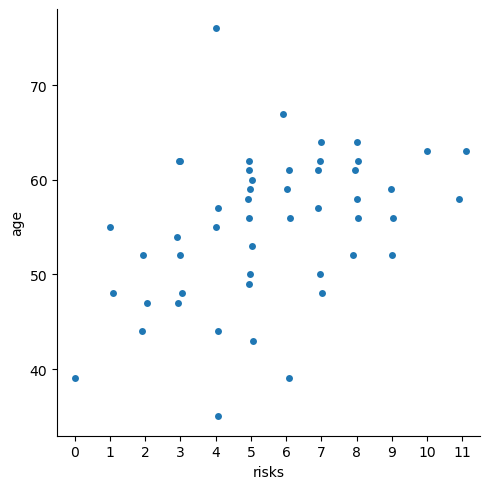

In [303]:
sns.catplot(data=data,x='risks',y='age')

<Axes: >

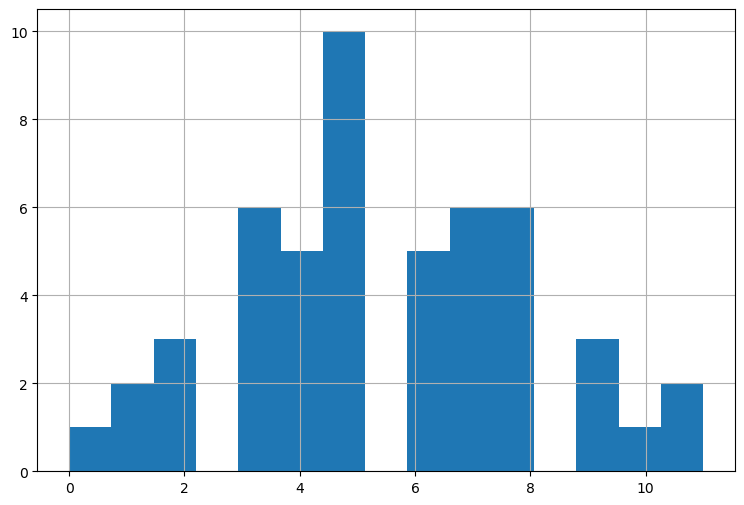

In [304]:
plt.figure(figsize=(9,6))
data['risks'].hist(bins=15)

In [305]:
# Ahora vamos a analizar los outliers 
for var in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
    tmp_data = data[var].dropna()
    q1, q3 = np.quantile(tmp_data, 0.25), np.quantile(tmp_data, 0.75)
    iqr = q3 - q1
    lower, upper = q1 - iqr * 1.5, q3 + iqr * 1.5
    n_out = tmp_data[(tmp_data < lower) | (tmp_data > upper)].shape[0]
    print(f"{var} - min: {tmp_data.min()} - lower_limit: {lower} - Q1: {q1} - Q3: {q3} - IQR: {iqr} - upper_limit: {upper} - max: {tmp_data.max()} - outliers: {n_out}")
        

age - min: 35.0 - lower_limit: 33.5 - Q1: 50.0 - Q3: 61.0 - IQR: 11.0 - upper_limit: 77.5 - max: 76.0 - outliers: 0
trestbps - min: 94.0 - lower_limit: 89.25 - Q1: 120.0 - Q3: 140.5 - IQR: 20.5 - upper_limit: 171.25 - max: 190.0 - outliers: 1
chol - min: 153.0 - lower_limit: 103.5 - Q1: 216.75 - Q3: 292.25 - IQR: 75.5 - upper_limit: 405.5 - max: 491.0 - outliers: 2
thalach - min: 92.0 - lower_limit: 75.0 - Q1: 120.0 - Q3: 150.0 - IQR: 30.0 - upper_limit: 195.0 - max: 179.0 - outliers: 0
oldpeak - min: 0.0 - lower_limit: -3.1875 - Q1: 0.0 - Q3: 2.125 - IQR: 2.125 - upper_limit: 5.3125 - max: 5.0 - outliers: 0


In [306]:
data.loc[data['trestbps'] > 170, 'trestbps'] = 175
data.loc[data['oldpeak'] > 3.75, 'oldpeak'] = 3.75
data.loc[data['chol'] > 350, 'chol'] = 350

In [307]:
data[['fbs', 'restecg', 'exang', 'ca']] +=  1
data[categorical_vars] = data[categorical_vars].replace(np.nan, 0)

In [308]:
test_data = kernel.impute_new_data(data)

In [309]:
data = test_data.complete_data()
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_na_count,cat_na_count,na_count,age2,oldpeak2,thalach_max,thalach_diff,oldpeak_diff,risks
0,56.0,1.0,2.0,124.0,224.0,2.0,1.0,161.0,1.0,2.0,2.0,0.0,0.0,0,2,2,5.0,1,160.8,-0.2,1.5,6
1,61.0,1.0,4.0,125.0,236.0,1.0,1.0,105.0,2.0,0.0,3.0,0.0,7.0,1,1,2,6.0,0,157.3,52.3,-0.8,6
2,52.0,1.0,4.0,135.0,282.0,0.0,1.0,128.0,2.0,2.0,2.0,0.0,7.0,1,2,3,5.0,1,163.6,35.6,1.5,9
3,64.0,1.0,4.0,120.0,233.0,2.0,2.0,106.0,1.0,2.0,2.0,0.0,0.0,1,2,3,6.0,1,155.2,49.2,1.2,7
4,49.0,1.0,1.0,130.0,231.0,1.0,2.0,145.0,1.0,3.0,2.0,0.0,0.0,1,2,3,4.0,1,165.7,20.7,2.7,5


In [121]:
# Create kernels. 
kernel = mf.ImputationKernel(
  data=data,
  save_all_iterations=True,
  random_state=1
)
kernel.mice(25)
data = kernel.complete_data()

data[numerical_vars].describe()

,age,trestbps,chol,thalach,oldpeak
count,50.000000,50.000000,50.00000,50.00000,50.000000
mean,55.120000,132.260000,253.28000,134.94000,1.302000
std,7.922172,16.887152,47.05448,22.18421,1.195952
min,35.000000,94.000000,153.00000,92.00000,0.000000
25%,50.000000,120.000000,219.25000,120.00000,0.000000
50%,56.000000,130.000000,255.50000,140.00000,1.000000
75%,61.000000,140.000000,279.00000,150.00000,2.000000
max,76.000000,175.000000,350.00000,179.00000,3.750000


In [310]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           50 non-null     float64
 1   sex           50 non-null     float64
 2   cp            50 non-null     float64
 3   trestbps      50 non-null     float64
 4   chol          50 non-null     float64
 5   fbs           50 non-null     float64
 6   restecg       50 non-null     float64
 7   thalach       50 non-null     float64
 8   exang         50 non-null     float64
 9   oldpeak       50 non-null     float64
 10  slope         50 non-null     float64
 11  ca            50 non-null     float64
 12  thal          50 non-null     float64
 13  num_na_count  50 non-null     int64  
 14  cat_na_count  50 non-null     int64  
 15  na_count      50 non-null     int64  
 16  age2          50 non-null     float64
 17  oldpeak2      50 non-null     int64  
 18  thalach_max   50 non-null     fl

In [266]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_na_count,cat_na_count,na_count,age2,oldpeak2,thalach_max,thalach_diff,oldpeak_diff,risks
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,55.120000,0.780000,3.28000,132.960000,253.400000,1.100000,1.580000,134.94000,1.460000,1.282000,1.440000,0.420000,2.320000,0.400000,1.760000,2.16000,5.040000,0.600000,161.416000,26.476000,0.768000,5.500000
std,7.922172,0.418452,1.03095,17.300419,50.954962,0.614452,0.835195,22.18421,0.503457,1.209392,0.972269,0.905539,3.060212,0.606092,1.187692,1.51671,0.902604,0.494872,5.545521,21.775202,1.229641,2.589224
min,35.000000,0.000000,1.00000,94.000000,153.000000,0.000000,0.000000,92.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.000000,0.000000,146.800000,-16.300000,-0.800000,0.000000
25%,50.000000,1.000000,2.25000,120.000000,216.000000,1.000000,1.000000,120.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.00000,5.000000,0.000000,157.300000,9.375000,-0.300000,4.000000
50%,56.000000,1.000000,4.00000,130.000000,243.500000,1.000000,1.000000,140.00000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2.00000,5.000000,1.000000,160.800000,25.250000,0.550000,5.000000
75%,61.000000,1.000000,4.00000,141.500000,286.500000,1.000000,2.000000,150.00000,2.000000,2.000000,2.000000,0.000000,6.000000,1.000000,3.000000,3.00000,6.000000,1.000000,165.000000,40.875000,1.500000,7.000000
max,76.000000,1.000000,4.00000,175.000000,350.000000,2.000000,3.000000,179.00000,2.000000,3.750000,3.000000,4.000000,7.000000,3.000000,4.000000,6.00000,7.000000,1.000000,175.500000,74.400000,4.500000,11.000000


In [311]:
data.to_csv('../test_dataset_clean.csv', index=False)